In [111]:
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, learning_curve
from collections import defaultdict
from xgboost import XGBClassifier
import warnings
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, recall_score, f1_score
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
# import statsmodels.formula.api as sm
import statsmodels.api as sm
import statsmodels
import math
import seaborn as sns
from scipy.sparse import csr_matrix
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
os.environ['KMP_DUPLICATE_LIB_OK']='True'

warnings.filterwarnings('ignore')

# Helper functions

#### Model metrics

In [122]:
def calculate_model_metrics(df_dev_y, df_dev_pred, df_dev_pred_prob, df_test_y, df_test_pred, df_test_pred_prob):
    print("**Classification accuracy**")
    print("Accurary on development: {}".format(accuracy_score(df_dev_y, df_dev_pred)))
    print("Accuracy on test: {}".format(accuracy_score(df_test_y, df_test_pred)))
    print("\n")

    # 2. Logloss
    print("**Log loss**")
    print("Logloss on development: {}".format(log_loss(df_dev_y, df_dev_pred)))
    print("Logloss on test: {}".format(log_loss(df_test_y, df_test_pred)))
    print("\n")

    # 3. AUC
    print("**AUC**")
    print("AUC for development: {}".format(roc_auc_score(df_dev_y, df_dev_pred_prob)))
    print("AUC for test: {}".format(roc_auc_score(df_test_y, df_test_pred_prob)))
    print("\n")
    
    # 4. Average precision
    print("**Average precision**")
    print("Average precision for development: {}".format(average_precision_score(df_dev_y, df_dev_pred_prob)))
    print("Average precision for test: {}".format(average_precision_score(df_test_y, df_test_pred_prob))) 
    print("\n")
    
    # 5. Average recall
    print("**Average recall**")
    print("Average recall for development: {}".format(recall_score(df_dev_y, df_dev_pred)))
    print("Average recall for test: {}".format(recall_score(df_test_y, df_test_pred))) 
    print("\n")
    
    # 6. F-1 Score
    print("**F-1 Score**")
    print("Average F-1 for development: {}".format(f1_score(df_dev_y, df_dev_pred)))
    print("Average F-1 for test: {}".format(f1_score(df_test_y, df_test_pred))) 
    print("\n")
    
    # 7. Confusion matrix
    print("**Confusion matrix**")
    print("Confusion matrix for development: \n{}".format(confusion_matrix(df_dev_y, df_dev_pred)))
    print("Confision matrix for test: \n{}".format(confusion_matrix(df_test_y, df_test_pred)))
    

In [69]:
def decile_and_reliability_plots(df_dev_label, df_dev_pred_prob, df_test_label, df_test_pred_prob, titles = ["development", "test"]):
    fig1, axs1 = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(12, 4))
    fig2, axs2 = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(12, 4))
    plot_each(axs1[0], axs2[0], df_dev_label, df_dev_pred_prob, titles[0])
    plot_each(axs1[1], axs2[1], df_test_label, df_test_pred_prob, titles[1])

def plot_each(ax1, ax2, df_label, df_pred_prob, title):
    print(type(df_label), type(df_pred_prob))
    df_label = df_label.rename("label")
    # df_label = df_label.rename({df_label.columns[0]: "label"}, axis = "columns")
    # df_pred_prob = df_pred_prob.rename("pred_prob")
    df_pred_prob = df_pred_prob.rename(columns = {df_pred_prob.columns[0]: "pred_prob"})
    df_labels_with_probs = pd.concat([df_label, df_pred_prob], axis = 1).sort_values(by = ["pred_prob"])
    # df_labels_with_probs = concatenate_X_with_y(df_label, df_pred_prob).sort_values(by = ["pred_prob"])
    no_rows = len(df_labels_with_probs.index)
    df_labels_with_probs["reset_index"] = np.arange(no_rows)
    decile_bins = pd.cut(df_labels_with_probs["reset_index"], np.linspace(0, no_rows, 11), include_lowest = True, labels = np.arange(1, 11))
    score_bins = pd.cut(df_labels_with_probs["pred_prob"], np.linspace(0, 1, 11), include_lowest = True)
    df_labels_with_probs.groupby(decile_bins)["label", "pred_prob"].mean().plot(ax = ax1, kind = 'bar', title = title)
    df_labels_with_probs.groupby(score_bins)["label", "pred_prob"].mean().plot(ax = ax2, x = 'pred_prob', y = 'label', marker = 'o', legend = False)
    ax2.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), marker = '*')

#### Data visualization

In [152]:
def visualize_data(df_X, df_y=None):
    if df_y.empty:
        df = df_X
    else:
        df = concatenate_X_with_y(df_X, df_y)
            
    # 0. Sample rows:
    print("\n**Sample rows**\n")
    print(df.head())
    
    # 1. Summary statistics:
    print("\n**Summary statistics**\n")
    print(df.describe())
    
    # 2. Pairwise plots:
#     print("\n**Pairwise plots**\n")
#     sns.pairplot(df)
#     plt.show()
    
    # 3. Pearson correlations:
    print("\n**Pearson correlations**\n")
    corrs = df.corr('pearson')
    sns.heatmap(corrs, annot=True)
    plt.show()
    
    # 4. Spearman correlations:
    print("\n**Spearman correlations**\n")
    corrs = df.corr('spearman')
    sns.heatmap(corrs, annot=True)
    plt.show()
    
    # 5. Box plots:
    print("\n**Box plots**\n")
    plt.figure(figsize=(20,10))
    sns.boxplot(data = df_X)
    plt.show()

#### Model training

##### 1. Logistic regression

In [81]:
def logistic_regression_without_regularization(df_dev_X, df_dev_y, df_test_X, df_test_y):
    print("\n=====Logistic Regression (without regularization)=====\n")
    
    df_dev_X_with_constant = statsmodels.tools.add_constant(df_dev_X, prepend = True)
    df_test_X_with_constant = statsmodels.tools.add_constant(df_test_X, prepend = True)
    
    lr_model = sm.Logit(df_dev_y, df_dev_X_with_constant).fit()
    print(lr_model.summary())
    
    # Model performance on development data:
    df_dev_pred_prob = pd.DataFrame(lr_model.predict(exog = df_dev_X_with_constant), columns = ["pred_prob"], index = df_dev_X_with_constant.index)
    dev_predictions = ((df_dev_pred_prob["pred_prob"] >= 0.5)*1.0).values
    df_dev_pred = pd.DataFrame(dev_predictions, columns = ["pred"], index = df_dev_X_with_constant.index)
    df_dev_pred.hist(bins = 10)

    # Model performance on test data:
    df_test_pred_prob = pd.DataFrame(lr_model.predict(exog = df_test_X_with_constant), columns = ["pred_prob"], index = df_test_X_with_constant.index)
    test_predictions = ((df_test_pred_prob["pred_prob"] >= 0.5)*1.0).values
    df_test_pred = pd.DataFrame(test_predictions, columns = ["pred"], index = df_test_X_with_constant.index)
    df_test_pred.hist(bins = 10)

    # Calculate metrics
    calculate_model_metrics(df_dev_y, df_dev_pred, df_dev_pred_prob, df_test_y, df_test_pred, df_test_pred_prob)
    
    # Plot deciles
    decile_and_reliability_plots(df_dev_y, df_dev_pred_prob, df_test_y, df_test_pred_prob)
    plt.show()

##### 2. Regularized logistic regression

In [5]:
def logistic_regression_with_regularization(df_dev_X, df_dev_y, df_test_X, df_test_y, sample_weight= None):
    feats = list(df_dev_X.columns)
    print("\n=====Logistic Regression (with regularization)=====\n")
    params = {'penalty': ['l1', 'l2'], 'C': np.logspace(-3, 3, 2)}
    lr = LogisticRegression(class_weight='balanced')
    lr_cv = GridSearchCV(lr, n_jobs=4, param_grid=params, verbose=1, cv=5, scoring='average_precision')
    lr_cv.fit(df_dev_X, df_dev_y)
    # lr_cv.fit(csr_matrix(df_dev_X.values), df_dev_y.values.ravel(), groups=None, {'sample_weight': sample_weight})

    # Hyper-parameters
    print("Params: {}".format(params))

    # Optimal hyper-parameters
    print("Best params: {}".format(lr_cv.best_params_))

    # Best model performance
    print("Best model performance: {}".format(lr_cv.best_score_))

    # Best Model details
    best_model = lr_cv.best_estimator_
    lr_coefs = list(zip(feats,(best_model.coef_[0])))
    lr_sorted_coefs = sorted(lr_coefs, key=lambda k: abs(k[1]), reverse=True)
    lr_intercept = best_model.intercept_[0]
    print("\n".join([str(x) for x in [("Intercept", lr_intercept)] + lr_sorted_coefs])) 

    # Model performance on development data:
    df_dev_pred = pd.DataFrame(best_model.predict(df_dev_X), columns = ["pred"], index = df_dev_X.index)
    df_dev_pred_prob = pd.DataFrame(best_model.predict_proba(df_dev_X)[:, 1], columns = ["pred_prob"], index = df_dev_X.index)
    
    # Model performance on test data:
    df_test_pred = pd.DataFrame(best_model.predict(df_test_X), columns = ["pred"], index = df_test_X.index)
    df_test_pred_prob = pd.DataFrame(best_model.predict_proba(df_test_X)[:, 1], columns = ["pred_prob"], index = df_test_X.index)

    # Calculate metrics
    calculate_model_metrics(df_dev_y, df_dev_pred, df_dev_pred_prob, df_test_y, df_test_pred, df_test_pred_prob)
    
    # Plot deciles
    decile_and_reliability_plots(df_dev_y, df_dev_pred_prob, df_test_y, df_test_pred_prob)
    plt.show()
    return (df_dev_pred, df_dev_pred_prob, df_test_pred, df_dev_pred_prob)

##### 3. XGBoost

In [6]:
def XGBoost_classifier(df_dev_X, df_dev_y, df_test_X, df_test_y):
    feats = list(df_dev_X.columns)
    pos_samples = (df_dev_y == 1).values.sum()
    neg_samples = (df_dev_y == 0).values.sum()
    scaling_factor = (neg_samples*1.0)/pos_samples
    print("\n=====XGBoost Classifier=====\n")
    params = {"numRound": [200], 
              "numEarlyStoppingRounds": [50], 
              "eta": [0.1], 
              "gamma": [0.0], 
              "maxDepth": [3],
              "minChildWeight": [1.0],
              "subsample": [0.8], 
              "colsampleBytree": [1.0], 
              "colsampleBylevel": [1.0],
              "lambda": [1.0],
              "alpha": [1.0], 
              "scale_pos_weight": [scaling_factor]
             }
    xgbc = XGBClassifier()
    xgbc_cv = GridSearchCV(xgbc, n_jobs=4, param_grid=params, verbose=1, cv=3, scoring='average_precision')
    xgbc_cv.fit(df_dev_X, df_dev_y)
    
    # Hyper-parameters
    print("Params: {}".format(params))

    # Optimal hyper-parameters
    print("Best params: {}".format(xgbc_cv.best_params_))

    # Best model performance
    print("Best model performance: {}".format(xgbc_cv.best_score_))

    # Best Model details
    best_model = xgbc_cv.best_estimator_
    xgbc_feats_imp = list(zip(feats,best_model.feature_importances_))
    xgbc_sorted_feats_imp = sorted(xgbc_feats_imp, key=lambda k: k[1], reverse=True)
    print("Feature importances:")
    print("\n".join([str(x) for x in xgbc_sorted_feats_imp])) 

    # Model performance on development data:
    df_dev_pred = pd.DataFrame(best_model.predict(df_dev_X), columns = ["pred"], index = df_dev_X.index)
    df_dev_pred_prob = pd.DataFrame(best_model.predict_proba(df_dev_X)[:, 1], columns = ["pred_prob"], index = df_dev_X.index)
    
    # Model performance on test data:
    df_test_pred = pd.DataFrame(best_model.predict(df_test_X), columns = ["pred"], index = df_test_X.index)
    df_test_pred_prob = pd.DataFrame(best_model.predict_proba(df_test_X)[:, 1], columns = ["pred_prob"], index = df_test_X.index)

    # Calculate metrics
    calculate_model_metrics(df_dev_y, df_dev_pred, df_dev_pred_prob, df_test_y, df_test_pred, df_test_pred_prob)
    
    # Plot deciles
    decile_and_reliability_plots(df_dev_y, df_dev_pred_prob, df_test_y, df_test_pred_prob)
    plt.show()


#### Utility functions

In [53]:
def concatenate_X_with_y(df_X, df_y): 
    return df_X.merge(df_y, left_index = True, right_index = True, validate = "1:1")

In [149]:
list(zip(x.index, x.values))

[(0, 284315), (1, 492)]

#### 1. Loading data

In [7]:
df = pd.read_csv("creditcard2.csv")

In [8]:
# checking the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
# creating features
label_col = ["Class"]
feats_with_label = list(df.columns)
feats = [x for x in feats_with_label if x not in label_col]
plotting_feats = [feat for feat in feats if feat!= 'Time']
model_feats = [feat for feat in feats if feat not in ['Time', 'Class', 'Amount']]

In [10]:
# defining major and minor classes
df_major_class = df[df.Class.eq(0)]
df_minor_class = df[df.Class.eq(1)]

In [11]:
# splitting into test and development datasets
df_dev, df_test = train_test_split(df, test_size = 0.2, random_state = 100, stratify = df["Class"])
df_dev_0 = df_dev[df_dev["Class"] == 0]
df_dev_1 = df_dev[df_dev["Class"] == 1]
df_test_0 = df_test[df_test["Class"] == 0]
df_test_1 = df_test[df_test["Class"] == 1]
df_dev_X = df_dev[feats]
df_dev_y = df_dev[label_col]
df_test_X = df_test[feats]
df_test_y = df_test[label_col]

#### 2. Data checks
First, we would like to perfrom data checks to ensure data quality. We check for the following:
* Missing values
* Outliers
* Class imbalance

##### **2.1. Missing values**

In [12]:
df.isna().values.any()

False

##### **2.2. Outliers**

<AxesSubplot:>

Text(0.5, 0, 'feature')

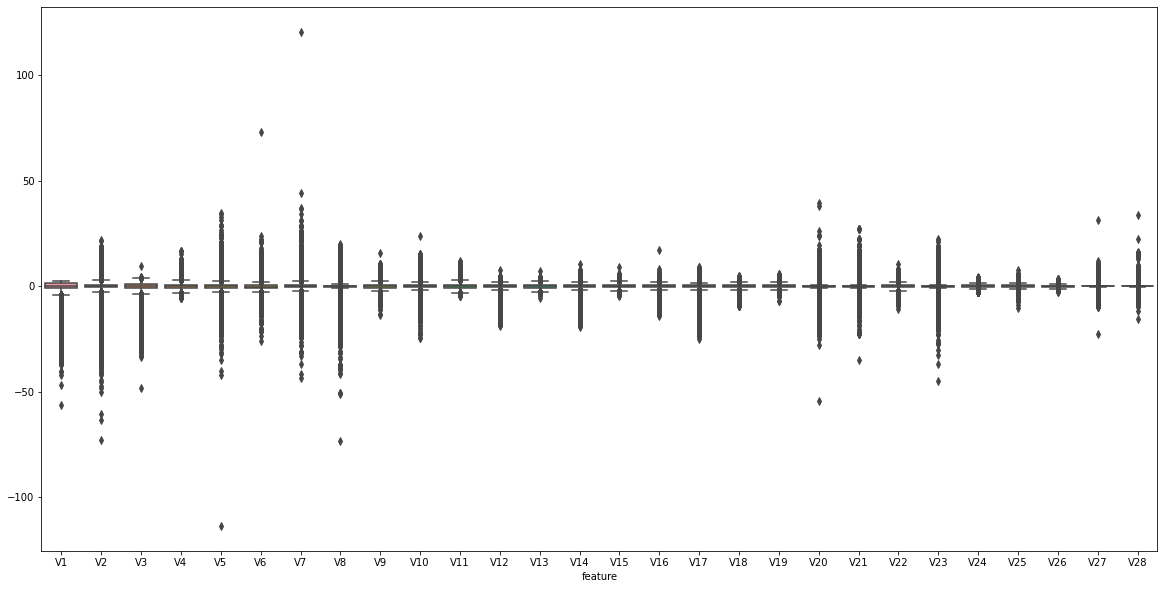

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data = df[model_feats], ax=ax)
ax.set_xlabel("feature")
# plt.show()

The features V5, V6 and V7 have outliers. We apply thresholding to remove them.

In [14]:
# checking statistics of V5
df['V5'].describe()

count    2.848070e+05
mean     9.604066e-16
std      1.380247e+00
min     -1.137433e+02
25%     -6.915971e-01
50%     -5.433583e-02
75%      6.119264e-01
max      3.480167e+01
Name: V5, dtype: float64

In [15]:
# deleting outlier in V5
df = df[df.V5 != df['V5'].min()]
df['V5'].describe()
# deleting the row fixed outliers of V5, V6 and V7

count    284806.000000
mean          0.000399
std           1.363694
min         -42.147898
25%          -0.691592
50%          -0.054334
75%           0.611927
max          34.801666
Name: V5, dtype: float64

<AxesSubplot:>

Text(0.5, 0, 'feature')

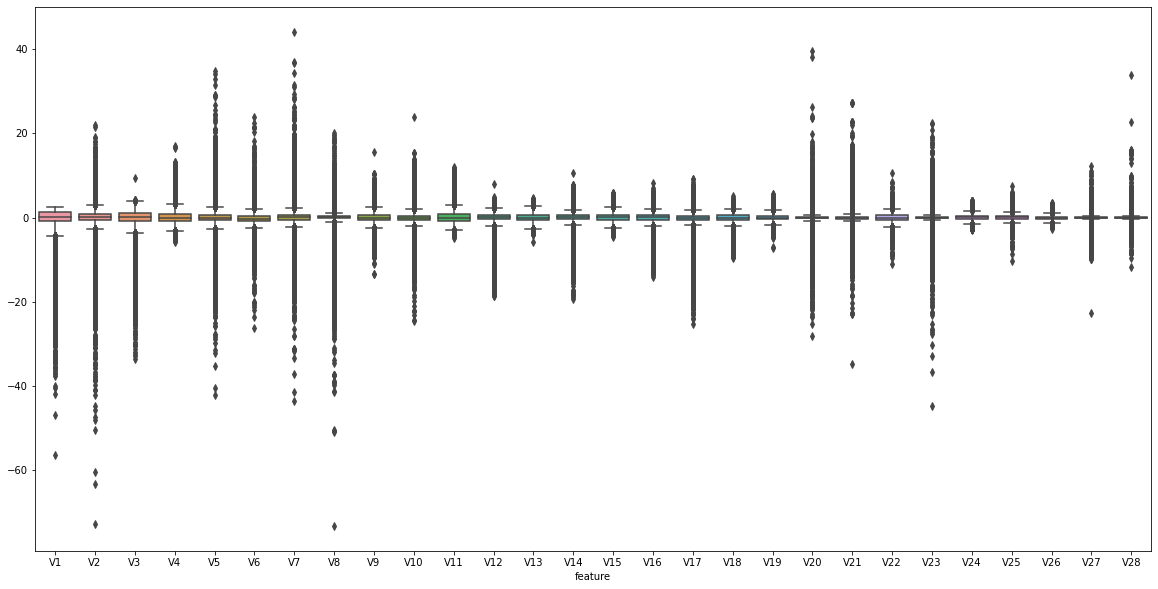

In [16]:
# checking throug boxplot again V5, V6 and V7
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data = df[model_feats], ax=ax)
ax.set_xlabel("feature")
# plt.show()

**2.3. Class imbalance**

In [18]:
major_class = (df["Class"] == 0).sum()/(df.shape[0]*1.0)
minor_class = (df["Class"] == 1).sum()/(df.shape[0]*1.0)
print(df["Class"].value_counts())
print("Original distrbutions - class 0: " + str(major_class))
print("Original distrbutions - class 1: " + str(minor_class))

0    284314
1       492
Name: Class, dtype: int64
Original distrbutions - class 0: 0.9982725083038981
Original distrbutions - class 1: 0.001727491696101908


The classes are highly imbalanced. We apply the following methodologies (below) to correct for class imbalance:
* Under-sampling of major class
* Over-sampling of minor class
* Synthetic sampling (SMOTE)

**2.3.1. Under-sampling of major class**

Class ratio is defined as the ratio of major class to minor class.

In [88]:
# Function for Under Sampling and Over Sampling 
def sample_df(df, class_ratio: int, under_sampling: bool = True, column: str = "Class", random_state: int = 42):
    major_class, minor_class = df[column].value_counts().argmax(),df[column].value_counts().argmin() 
    if under_sampling:
        major_class_sample = df[df[column] == major_class].sample(df[column].value_counts().min()*class_ratio, random_state=random_state)
        minor_class_sample = df[df[column] == minor_class]
    else:
        major_class_sample = df[df[column] == major_class]
        minor_class_sample = df[df[column] == minor_class].sample(df[column].value_counts().max(), replace = True, random_state=random_state)
    sampled_df = pd.concat([major_class_sample, minor_class_sample])
    return sampled_df

**2.3.1.1. Class ratio = 1**

In [89]:
class_ratio = 1
df_sampled_1 = sample_df(df,class_ratio)
df_sampled_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 138028 to 281674
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    984 non-null    float64
 1   V1      984 non-null    float64
 2   V2      984 non-null    float64
 3   V3      984 non-null    float64
 4   V4      984 non-null    float64
 5   V5      984 non-null    float64
 6   V6      984 non-null    float64
 7   V7      984 non-null    float64
 8   V8      984 non-null    float64
 9   V9      984 non-null    float64
 10  V10     984 non-null    float64
 11  V11     984 non-null    float64
 12  V12     984 non-null    float64
 13  V13     984 non-null    float64
 14  V14     984 non-null    float64
 15  V15     984 non-null    float64
 16  V16     984 non-null    float64
 17  V17     984 non-null    float64
 18  V18     984 non-null    float64
 19  V19     984 non-null    float64
 20  V20     984 non-null    float64
 21  V21     984 non-null    float64

In [150]:
df_sampled_1['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

**2.3.1.2. Class ratio = 10**

In [115]:
class_ratio = 10
df_sampled_10 = sample_df(df, class_ratio)
df_sampled_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5412 entries, 138028 to 281674
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    5412 non-null   float64
 1   V1      5412 non-null   float64
 2   V2      5412 non-null   float64
 3   V3      5412 non-null   float64
 4   V4      5412 non-null   float64
 5   V5      5412 non-null   float64
 6   V6      5412 non-null   float64
 7   V7      5412 non-null   float64
 8   V8      5412 non-null   float64
 9   V9      5412 non-null   float64
 10  V10     5412 non-null   float64
 11  V11     5412 non-null   float64
 12  V12     5412 non-null   float64
 13  V13     5412 non-null   float64
 14  V14     5412 non-null   float64
 15  V15     5412 non-null   float64
 16  V16     5412 non-null   float64
 17  V17     5412 non-null   float64
 18  V18     5412 non-null   float64
 19  V19     5412 non-null   float64
 20  V20     5412 non-null   float64
 21  V21     5412 non-null   float6

In [116]:
df_sampled_10['Class'].value_counts()

0    4920
1     492
Name: Class, dtype: int64

**2.3.1.3. Class ratio = 100**

In [124]:
class_ratio = 100
df_sampled_100 = sample_df(df, class_ratio)
df_sampled_100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49692 entries, 138028 to 281674
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    49692 non-null  float64
 1   V1      49692 non-null  float64
 2   V2      49692 non-null  float64
 3   V3      49692 non-null  float64
 4   V4      49692 non-null  float64
 5   V5      49692 non-null  float64
 6   V6      49692 non-null  float64
 7   V7      49692 non-null  float64
 8   V8      49692 non-null  float64
 9   V9      49692 non-null  float64
 10  V10     49692 non-null  float64
 11  V11     49692 non-null  float64
 12  V12     49692 non-null  float64
 13  V13     49692 non-null  float64
 14  V14     49692 non-null  float64
 15  V15     49692 non-null  float64
 16  V16     49692 non-null  float64
 17  V17     49692 non-null  float64
 18  V18     49692 non-null  float64
 19  V19     49692 non-null  float64
 20  V20     49692 non-null  float64
 21  V21     49692 non-null  float

In [25]:
df_sampled_100['Class'].value_counts()

0    49200
1      492
Name: Class, dtype: int64

**2.3.2. Over-sampling of minor class**

In [27]:
class_ratio = 1
df_sampled_oversampling = sample_df(df,class_ratio,False)
df_sampled_oversampling['Class'].value_counts()

1    284314
0    284314
Name: Class, dtype: int64

**2.3.3. Synthetic sampling (SMOTE)**

In [28]:
#pip install imbalanced-learn

In [129]:
import imblearn
from imblearn.over_sampling import SMOTE

In [130]:
# separating major and minor class
X = df.drop('Class', axis = 1)
y = df['Class']

In [134]:
#transforming the dataset
oversample = SMOTE()
X_SMOTE, y_SMOTE = oversample.fit_resample(X, y)

In [133]:
y_resampled.value_counts()

1    284314
0    284314
Name: Class, dtype: int64

### 2.4 Visualization

In [153]:
# entire dataset
df_X = df.drop(['Class', 'Time', 'Amount'], axis = 1)
df_y = df['Class']


**Sample rows**

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0  0.098698  0.363787  0.090794  ...  0.251412 -0.018307  0.277838 -0.110474   
1  0.085102 -0.255425 -0.166974  ... -0.069083 -0.225775 -0.638672  0.101288   
2  0.247676 -1.514654  0.207643  ...  0.524980  0.247998  0.771679  0.909412   
3  0.377436 -1.387024 -0.054952  ... -0.208038 -0.108300  0.005274 -0.190321   
4 -0.270533  0.817739  0.753074  ...  0.408542 -0.009431  0.798278 -0.137458   

        V24       V25       V26       V27       V2

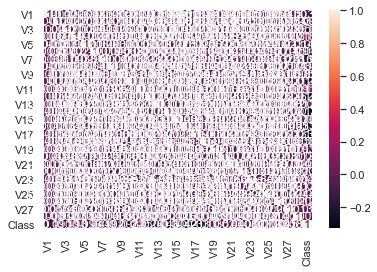


**Spearman correlations**



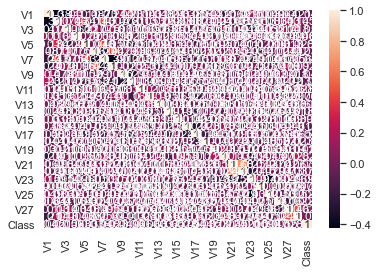


**Box plots**



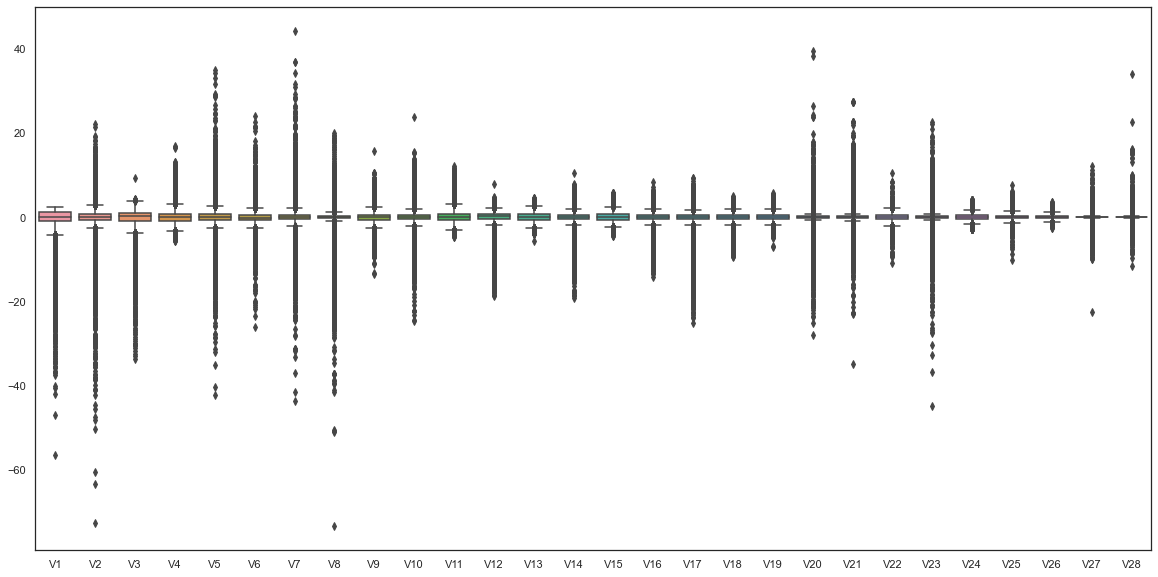

In [154]:
visualize_data(df_X, df_y)

### 3. Modeling

###  3.1  Logistic Regression

In [108]:
# entire dataset
df_X = df.drop(['Class', 'Time', 'Amount'], axis = 1)
df_y = df['Class']

In [109]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42, stratify = df_y)
logistic_regression_without_regularization(X_train, y_train, X_test, y_test)

In [90]:
# Undersampling with class ratio = 1
df_sampled_1_X = df_sampled_1.drop(['Class', 'Time', 'Amount'], axis = 1)
df_sampled_1_y = df_sampled_1['Class']

In [93]:
X_train_sampled_1, X_test_sampled_1, y_train_sampled_1, y_test_sampled_1 = train_test_split(df_sampled_1_X, df_sampled_1_y, test_size=0.2, random_state=42, stratify = df_sampled_1_y)
logistic_regression_without_regularization(X_train_sampled_1, y_train_sampled_1, X_test_sampled_1, y_test_sampled_1)

In [119]:
# Undersampling with class ratio = 10
df_sampled_10_X = df_sampled_10.drop(['Class', 'Time', 'Amount'], axis = 1)
df_sampled_10_y = df_sampled_10['Class']


=====Logistic Regression (without regularization)=====

Optimization terminated successfully.
         Current function value: 0.055259
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                 4329
Model:                          Logit   Df Residuals:                     4300
Method:                           MLE   Df Model:                           28
Date:                Sun, 27 Dec 2020   Pseudo R-squ.:                  0.8187
Time:                        20:55:42   Log-Likelihood:                -239.22
converged:                       True   LL-Null:                       -1319.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5854      0.280    -19.982      0

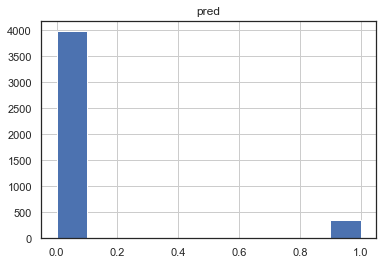

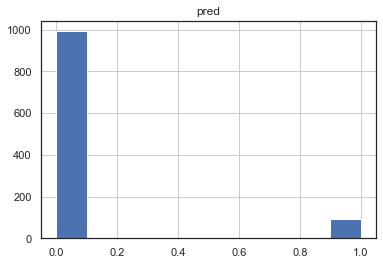

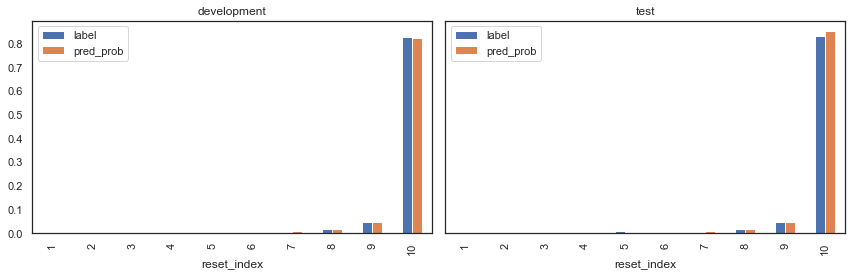

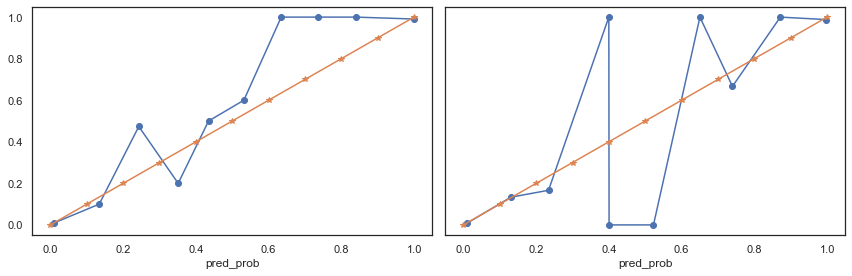

In [120]:
X_train_sampled_10, X_test_sampled_10, y_train_sampled_10, y_test_sampled_10 = train_test_split(df_sampled_10_X, df_sampled_10_y, test_size=0.2, random_state=42, stratify = df_sampled_10_y)
logistic_regression_without_regularization(X_train_sampled_10, y_train_sampled_10, X_test_sampled_10, y_test_sampled_10)

In [125]:
# Undersampling with class ratio = 100
df_sampled_100_X = df_sampled_100.drop(['Class', 'Time', 'Amount'], axis = 1)
df_sampled_100_y = df_sampled_100['Class']


=====Logistic Regression (without regularization)=====

Optimization terminated successfully.
         Current function value: 0.011490
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                39753
Model:                          Logit   Df Residuals:                    39724
Method:                           MLE   Df Model:                           28
Date:                Sun, 27 Dec 2020   Pseudo R-squ.:                  0.7933
Time:                        21:30:26   Log-Likelihood:                -456.76
converged:                       True   LL-Null:                       -2210.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.3100      0.197    -37.141      0

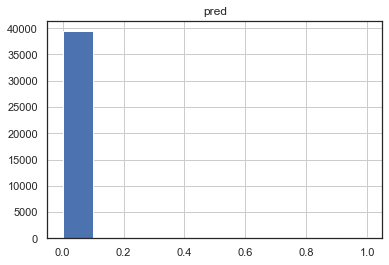

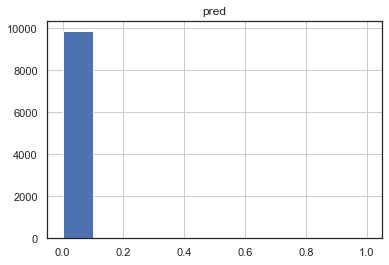

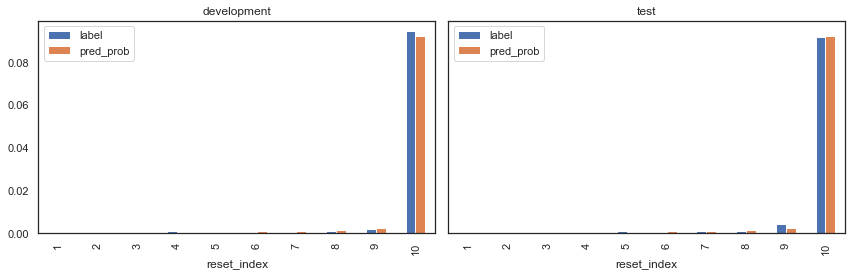

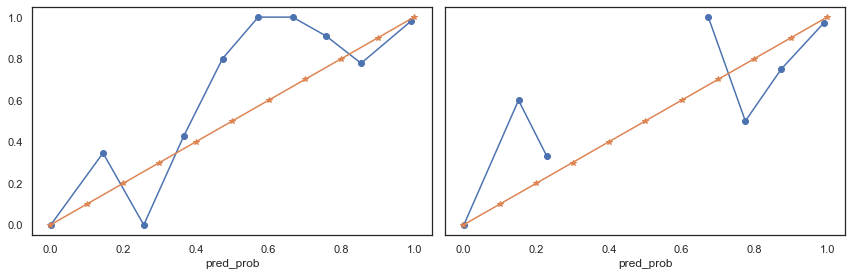

In [126]:
X_train_sampled_100, X_test_sampled_100, y_train_sampled_100, y_test_sampled_100 = train_test_split(df_sampled_100_X, df_sampled_100_y, test_size=0.2, random_state=42, stratify = df_sampled_100_y)
logistic_regression_without_regularization(X_train_sampled_100, y_train_sampled_100, X_test_sampled_100, y_test_sampled_100)

In [127]:
# Oversampling
df_sampled_oversampling_X = df_sampled_oversampling.drop(['Class', 'Time', 'Amount'], axis = 1)
df_sampled_oversampling_y = df_sampled_oversampling['Class']



=====Logistic Regression (without regularization)=====

Optimization terminated successfully.
         Current function value: 0.137855
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:               454902
Model:                          Logit   Df Residuals:                   454873
Method:                           MLE   Df Model:                           28
Date:                Sun, 27 Dec 2020   Pseudo R-squ.:                  0.8011
Time:                        21:33:53   Log-Likelihood:                -62711.
converged:                       True   LL-Null:                   -3.1531e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4527      0.014   -247.591      0

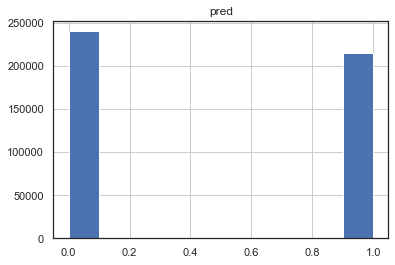

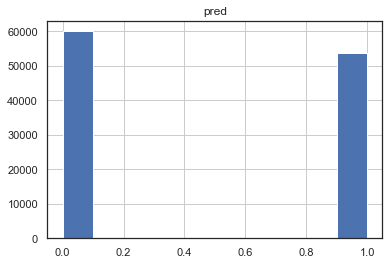

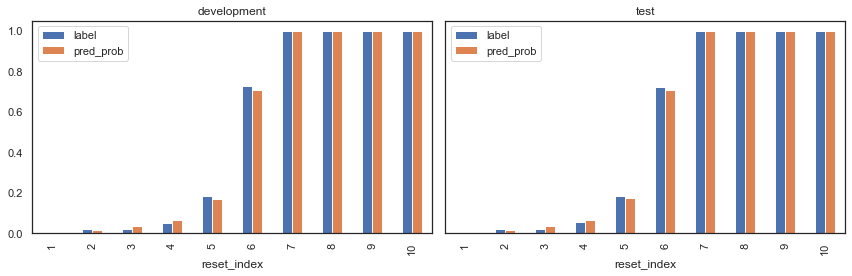

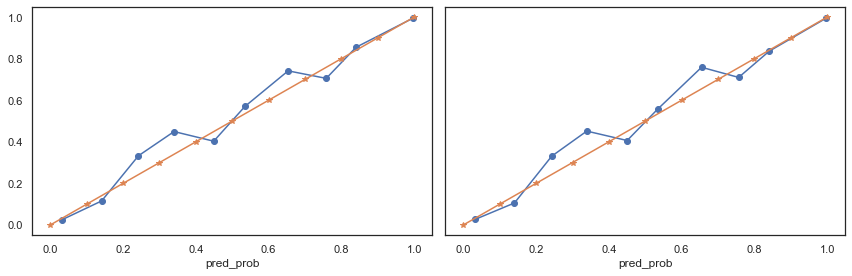

In [128]:
X_train_oversampling, X_test_oversampling, y_train_oversampling, y_test_oversampling = train_test_split(df_sampled_oversampling_X, df_sampled_oversampling_y, test_size=0.2, random_state=42, stratify = df_sampled_oversampling_y)
logistic_regression_without_regularization(X_train_oversampling, y_train_oversampling, X_test_oversampling, y_test_oversampling)

In [136]:
#SMOTE Dataset
df_SMOTE_X = X_SMOTE.drop(['Time', 'Amount'], axis = 1)
df_SMOTE_y = y_SMOTE


=====Logistic Regression (without regularization)=====

Optimization terminated successfully.
         Current function value: 0.063119
         Iterations 16
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:               454902
Model:                          Logit   Df Residuals:                   454873
Method:                           MLE   Df Model:                           28
Date:                Sun, 27 Dec 2020   Pseudo R-squ.:                  0.9089
Time:                        21:38:02   Log-Likelihood:                -28713.
converged:                       True   LL-Null:                   -3.1531e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1843      0.027   -189.565      0

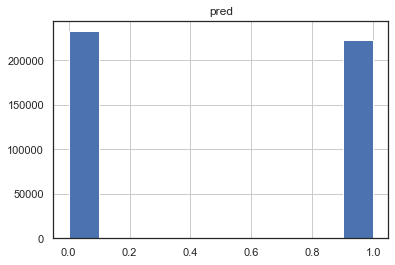

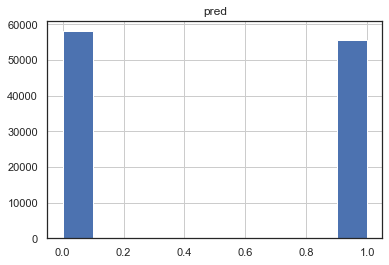

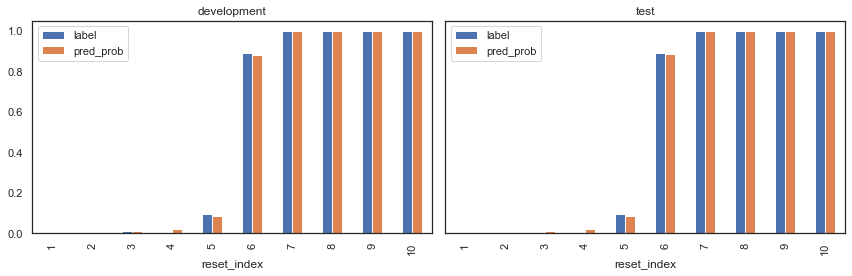

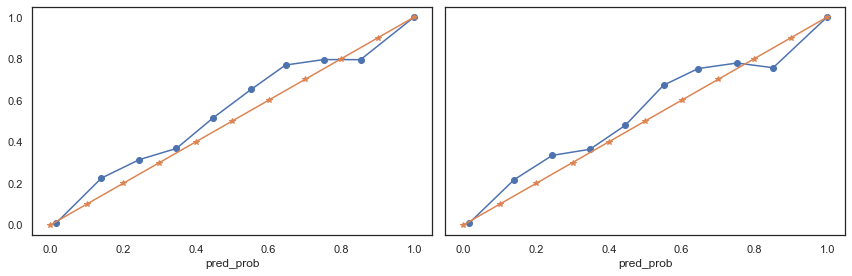

In [137]:
X_train_SMOTE, X_test_SMOTE, y_train_SMOTE, y_test_SMOTE = train_test_split(df_SMOTE_X, df_SMOTE_y, test_size=0.2, random_state=42, stratify = df_SMOTE_y)
logistic_regression_without_regularization(X_train_SMOTE, y_train_SMOTE, X_test_SMOTE, y_test_SMOTE)

### 3.2 Logistic with Regularization


=====Logistic Regression (with regularization)=====

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Params: {'penalty': ['l1', 'l2'], 'C': array([1.e-03, 1.e+03])}
Best params: {'C': 0.001, 'penalty': 'l2'}
Best model performance: 0.9848611261013186
('Intercept', -1.4469581419115967)
('V14', -0.16803948813035877)
('V4', 0.14281321589053556)
('V12', -0.11129204500482168)
('V3', -0.09659310254694542)
('V10', -0.09575193452733982)
('V11', 0.07476598214551373)
('V16', -0.046385650544511645)
('V9', -0.04558118934278999)
('V1', -0.04433449207223317)
('V17', -0.03584482416023759)
('V8', -0.03476613097950589)
('V7', -0.032035382825346445)
('V2', 0.029336501508122545)
('V6', -0.029222805957022938)
('V13', -0.027443483357467813)
('V21', 0.016804687027489138)
('V23', -0.010590241191822567)
('V5', 0.008417650419603368)
('V22', 0.008208708868355188)
('V20', 0.006236237808641871)
('V15', -0.005972568214785379)
('V28', 0.0050134882066153325)
('V27', 0.004092662677270559)
('V24', 0.00223

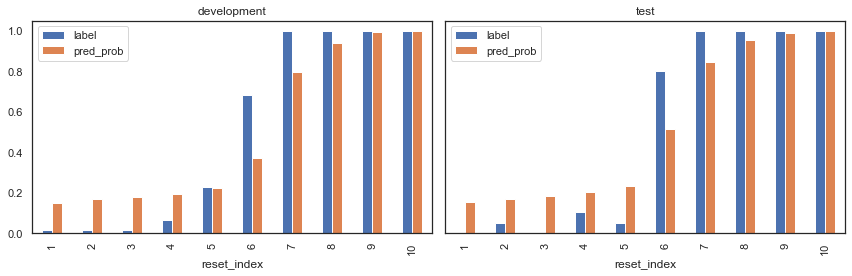

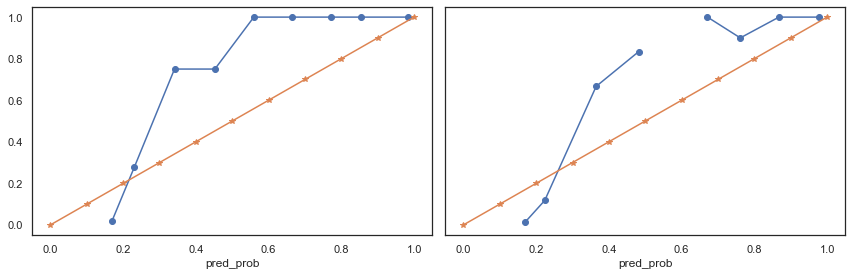

(        pred
 192205     0
 204804     0
 56703      0
 150684     1
 6882       1
 ...      ...
 39183      0
 103430     0
 143335     1
 191913     0
 17317      1
 
 [787 rows x 1 columns],
         pred_prob
 192205   0.152709
 204804   0.151327
 56703    0.265973
 150684   0.999785
 6882     0.985715
 ...           ...
 39183    0.299343
 103430   0.200099
 143335   0.997084
 191913   0.180301
 17317    0.999414
 
 [787 rows x 1 columns],
         pred
 230076     1
 262826     1
 251019     0
 30314      1
 211989     0
 ...      ...
 39763      0
 6472       1
 60765      0
 52466      1
 118986     0
 
 [197 rows x 1 columns],
         pred_prob
 192205   0.152709
 204804   0.151327
 56703    0.265973
 150684   0.999785
 6882     0.985715
 ...           ...
 39183    0.299343
 103430   0.200099
 143335   0.997084
 191913   0.180301
 17317    0.999414
 
 [787 rows x 1 columns])

In [139]:
# Under Sampling with Class Ratio # 1
logistic_regression_with_regularization(X_train_sampled_1, y_train_sampled_1, X_test_sampled_1, y_test_sampled_1)


=====Logistic Regression (with regularization)=====

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Params: {'penalty': ['l1', 'l2'], 'C': array([1.e-03, 1.e+03])}
Best params: {'C': 1000.0, 'penalty': 'l2'}
Best model performance: 0.9362478773510514
('Intercept', -3.651713992117083)
('V14', -1.6942143047183265)
('V12', -1.4227021674107674)
('V17', -1.332377535722042)
('V28', 1.205413258641716)
('V10', -1.1428631313208597)
('V16', -1.0717464265171424)
('V4', 1.0617780681630105)
('V8', -0.8542821110307254)
('V27', 0.8480158847928907)
('V11', 0.7515754611632663)
('V1', 0.5295213136850624)
('V22', 0.4961552232417255)
('V18', -0.42227263214569627)
('V9', -0.39952404455303714)
('V23', -0.38585830889816414)
('V2', -0.38545837045179904)
('V13', -0.29805827167628685)
('V25', -0.23547902857656738)
('V6', -0.23501107806539764)
('V7', 0.21837398392842944)
('V21', 0.20964139105633267)
('V24', 0.2051492472246158)
('V20', -0.18458272301512665)
('V3', 0.1531531198259634)
('V26', -0.1191

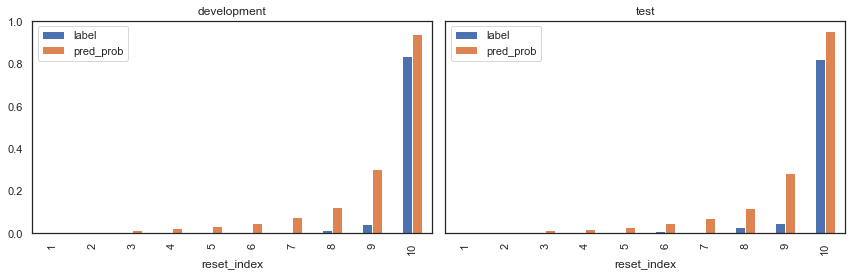

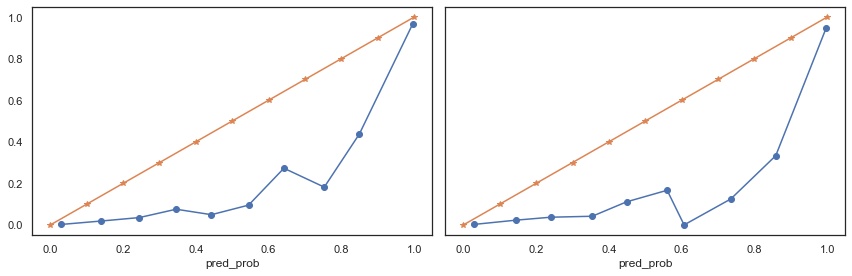

(        pred
 211067     1
 113745     0
 42573      0
 76132      0
 212124     0
 ...      ...
 48858      0
 126236     0
 150697     1
 99524      0
 145231     0
 
 [4329 rows x 1 columns],
         pred_prob
 211067   0.836412
 113745   0.052024
 42573    0.333136
 76132    0.075114
 212124   0.174076
 ...           ...
 48858    0.047019
 126236   0.071954
 150697   1.000000
 99524    0.000541
 145231   0.320890
 
 [4329 rows x 1 columns],
         pred
 89074      0
 66796      0
 219920     0
 13291      0
 150692     1
 ...      ...
 75075      0
 28478      0
 142557     0
 186360     0
 125834     0
 
 [1083 rows x 1 columns],
         pred_prob
 211067   0.836412
 113745   0.052024
 42573    0.333136
 76132    0.075114
 212124   0.174076
 ...           ...
 48858    0.047019
 126236   0.071954
 150697   1.000000
 99524    0.000541
 145231   0.320890
 
 [4329 rows x 1 columns])

In [140]:
# Under Sampling with Class Ratio = 10
logistic_regression_with_regularization(X_train_sampled_10, y_train_sampled_10, X_test_sampled_10, y_test_sampled_10)


=====Logistic Regression (with regularization)=====

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Params: {'penalty': ['l1', 'l2'], 'C': array([1.e-03, 1.e+03])}
Best params: {'C': 1000.0, 'penalty': 'l2'}
Best model performance: 0.8686474229555138
('Intercept', -3.4663443471858737)
('V14', -1.3558352449671793)
('V12', -1.1319753605331089)
('V4', 0.9186557044882959)
('V16', -0.7025989336810469)
('V17', -0.6822607140263011)
('V10', -0.6634530910480892)
('V11', 0.6397050758997713)
('V8', -0.6302857082277175)
('V27', 0.6070651614106455)
('V28', 0.5900032944278465)
('V22', 0.49937835118513985)
('V9', -0.3896000822488168)
('V1', 0.3059675529732933)
('V6', -0.26883022996323064)
('V23', -0.22072198555539013)
('V19', 0.21545252892791622)
('V18', -0.21086345970629602)
('V2', -0.2065398578764937)
('V13', -0.2020553848511682)
('V21', 0.1723645124503549)
('V20', -0.16169714731152274)
('V5', 0.1456567804184667)
('V15', -0.13964158011985106)
('V26', -0.13266533857529073)
('V24', -0.1

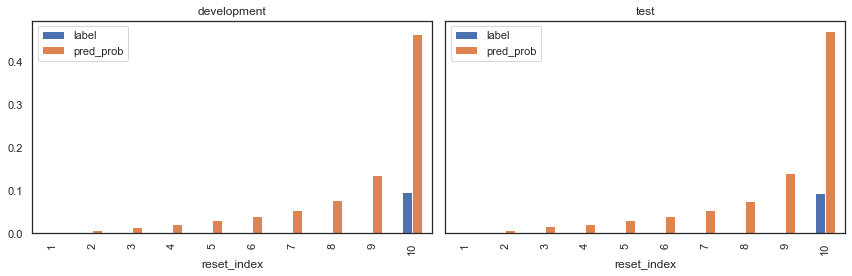

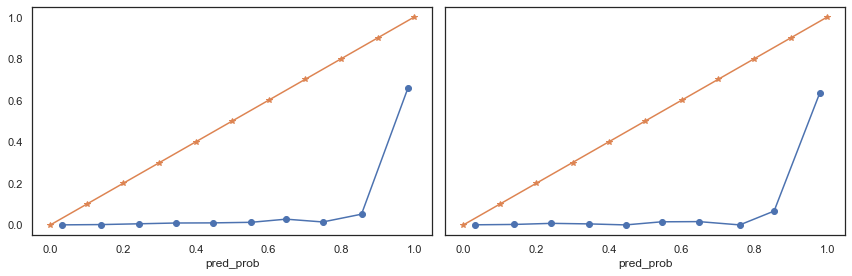

(        pred
 8926       0
 154437     0
 104399     0
 154884     0
 233991     0
 ...      ...
 261929     0
 148082     0
 278460     0
 271510     0
 190484     0
 
 [39753 rows x 1 columns],
         pred_prob
 8926     0.143841
 154437   0.030716
 104399   0.002840
 154884   0.091177
 233991   0.008879
 ...           ...
 261929   0.000041
 148082   0.081356
 278460   0.023965
 271510   0.033632
 190484   0.035112
 
 [39753 rows x 1 columns],
         pred
 75456      0
 19482      0
 36168      0
 162515     0
 111864     0
 ...      ...
 23605      0
 283341     0
 63501      0
 221809     0
 243123     0
 
 [9939 rows x 1 columns],
         pred_prob
 8926     0.143841
 154437   0.030716
 104399   0.002840
 154884   0.091177
 233991   0.008879
 ...           ...
 261929   0.000041
 148082   0.081356
 278460   0.023965
 271510   0.033632
 190484   0.035112
 
 [39753 rows x 1 columns])

In [141]:
# Under Sampling with Class Ratio = 100
logistic_regression_with_regularization(X_train_sampled_100, y_train_sampled_100, X_test_sampled_100, y_test_sampled_100)


=====Logistic Regression (with regularization)=====

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Params: {'penalty': ['l1', 'l2'], 'C': array([1.e-03, 1.e+03])}
Best params: {'C': 1000.0, 'penalty': 'l2'}
Best model performance: 0.9890118975924433
('Intercept', -3.4527790617925564)
('V14', -1.2462774690806857)
('V12', -1.0699603111716225)
('V4', 0.9633373707849637)
('V10', -0.9137922423549716)
('V17', -0.7258789685924283)
('V16', -0.6440324866186994)
('V8', -0.6346481662761445)
('V11', 0.5530069502569676)
('V28', 0.48416725244072123)
('V22', 0.4731347823201403)
('V26', -0.4093537138082216)
('V27', 0.383457084889401)
('V9', -0.37468598930061414)
('V13', -0.3411887832276093)
('V1', 0.2996029341176659)
('V23', -0.2770216232881656)
('V2', -0.2758112021678593)
('V21', 0.2609727097919689)
('V18', -0.2329922728900884)
('V6', -0.2308833099305307)
('V7', 0.15461674335713238)
('V19', 0.153589085096197)
('V25', -0.14821492968214944)
('V5', 0.1371329189392852)
('V20', -0.079331855

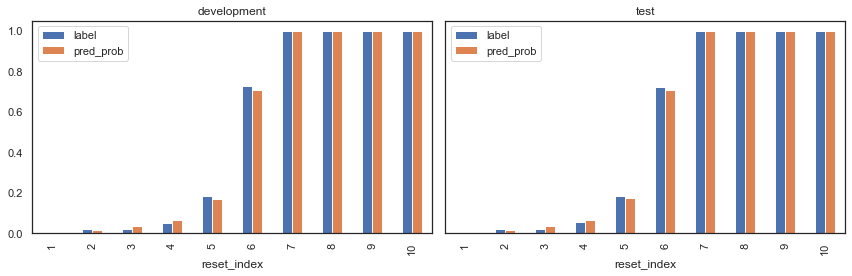

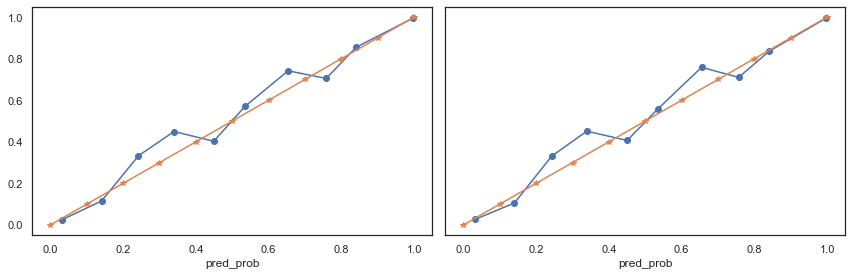

(        pred
 225907     0
 154030     0
 15736      1
 276397     0
 203834     0
 ...      ...
 194455     0
 41904      0
 149522     1
 231978     1
 192687     1
 
 [454902 rows x 1 columns],
         pred_prob
 225907   0.015201
 154030   0.024627
 15736    1.000000
 276397   0.003456
 203834   0.017677
 ...           ...
 194455   0.184686
 41904    0.071017
 149522   1.000000
 231978   0.927967
 192687   0.610761
 
 [454902 rows x 1 columns],
         pred
 10897      1
 45203      1
 81077      0
 236854     0
 120837     1
 ...      ...
 260737     0
 243393     1
 274475     1
 114271     1
 231978     1
 
 [113726 rows x 1 columns],
         pred_prob
 225907   0.015201
 154030   0.024627
 15736    1.000000
 276397   0.003456
 203834   0.017677
 ...           ...
 194455   0.184686
 41904    0.071017
 149522   1.000000
 231978   0.927967
 192687   0.610761
 
 [454902 rows x 1 columns])

In [142]:
# Over sampling
logistic_regression_with_regularization(X_train_oversampling, y_train_oversampling, X_test_oversampling, y_test_oversampling)


=====Logistic Regression (with regularization)=====

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Params: {'penalty': ['l1', 'l2'], 'C': array([1.e-03, 1.e+03])}
Best params: {'C': 1000.0, 'penalty': 'l2'}
Best model performance: 0.9975207563920796
('Intercept', -5.18426605394103)
('V14', -2.044237786720281)
('V12', -1.8591431787122583)
('V17', -1.7988271729207446)
('V10', -1.710481663197632)
('V4', 1.2309440662907392)
('V11', 1.040029921236101)
('V16', -0.9870474822828252)
('V8', -0.9357674739754265)
('V9', -0.7852290121521318)
('V28', 0.7442534032298455)
('V1', 0.7296709686179046)
('V18', -0.7128083232635323)
('V27', 0.5758539688565786)
('V2', -0.5319416818706599)
('V22', 0.5048513446259644)
('V13', -0.43561527279128115)
('V19', 0.41616435716435407)
('V21', 0.3868944229408447)
('V25', -0.2984412536774943)
('V3', 0.26714675070158805)
('V6', -0.2616986190160475)
('V5', 0.237960607872407)
('V26', -0.22214283595635304)
('V20', -0.15631697652237667)
('V23', -0.136852924266

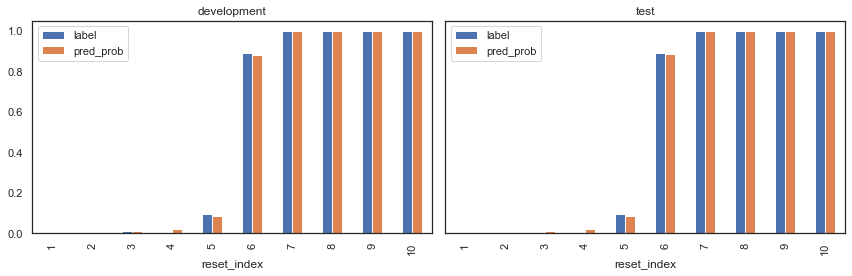

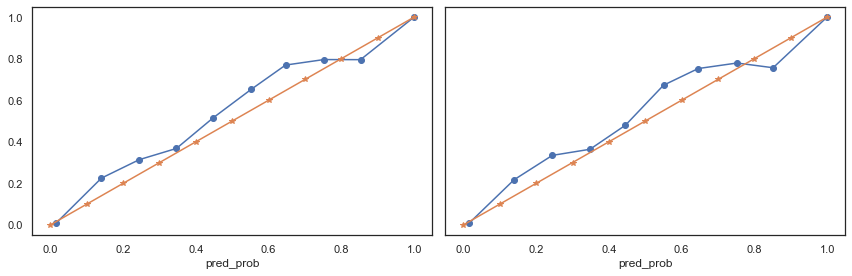

(        pred
 225907     0
 154030     0
 555597     1
 276396     0
 203834     0
 ...      ...
 194455     0
 41904      0
 445653     1
 509471     1
 432675     1
 
 [454902 rows x 1 columns],
         pred_prob
 225907   0.003811
 154030   0.009924
 555597   1.000000
 276396   0.000184
 203834   0.004990
 ...           ...
 194455   0.063158
 41904    0.026668
 445653   0.998361
 509471   1.000000
 432675   1.000000
 
 [454902 rows x 1 columns],
         pred
 464677     1
 390372     1
 81077      0
 236854     0
 407197     1
 ...      ...
 260737     0
 326575     1
 498585     1
 495780     1
 334703     0
 
 [113726 rows x 1 columns],
         pred_prob
 225907   0.003811
 154030   0.009924
 555597   1.000000
 276396   0.000184
 203834   0.004990
 ...           ...
 194455   0.063158
 41904    0.026668
 445653   0.998361
 509471   1.000000
 432675   1.000000
 
 [454902 rows x 1 columns])

In [143]:
#SMOTE
logistic_regression_with_regularization(X_train_SMOTE, y_train_SMOTE, X_test_SMOTE, y_test_SMOTE)

### 3.2 XG BOOST


=====XGBoost Classifier=====

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[21:45:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsampleBylevel, colsampleBytree, maxDepth, minChildWeight, numEarlyStoppingRounds, numRound } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:45:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Params: {'numRound': [200], 'numEarlyStoppingRounds': [50], 'eta': [0.1], 'gamma': [0.0], 'maxDepth': [3], 'minChildWeight': [1.0], 'subsample': [0.8], 'colsampleBytree': [1.0], 'colsam

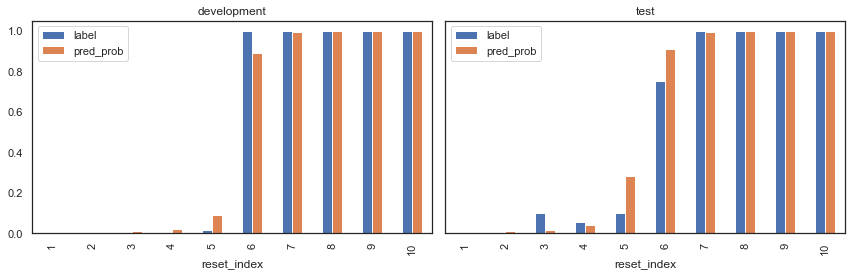

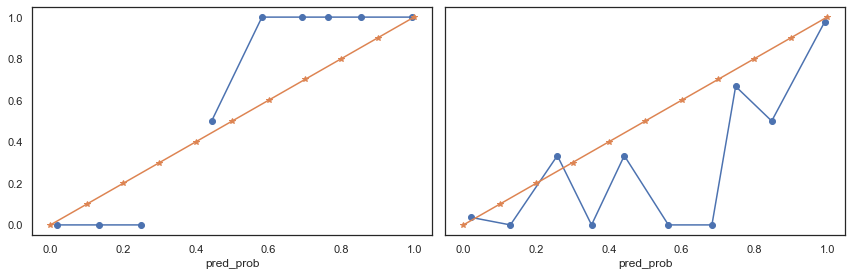

In [144]:
# Under Sampling with Class Ratio # 1
XGBoost_classifier(X_train_sampled_1, y_train_sampled_1, X_test_sampled_1, y_test_sampled_1)


=====XGBoost Classifier=====

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[21:47:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsampleBylevel, colsampleBytree, maxDepth, minChildWeight, numEarlyStoppingRounds, numRound } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:47:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Params: {'numRound': [200], 'numEarlyStoppingRounds': [50], 'eta': [0.1], 'gamma': [0.0], 'maxDepth': [3], 'minChildWeight': [1.0], 'subsample': [0.8], 'colsampleBytree': [1.0], 'colsam

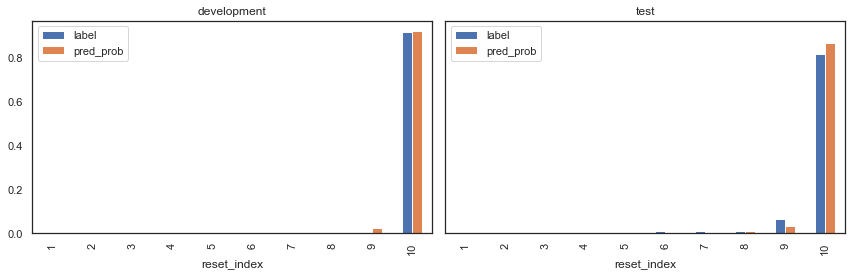

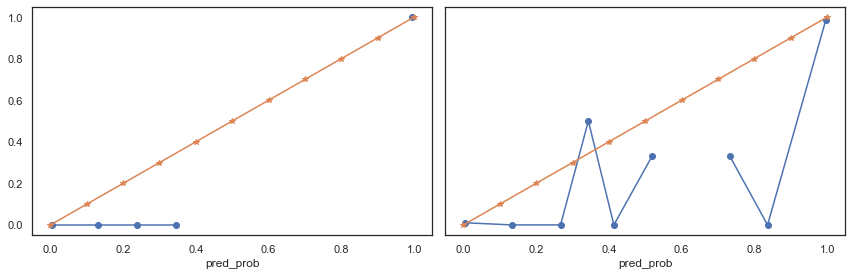

In [145]:
# Under Sampling with Class Ratio = 10
XGBoost_classifier(X_train_sampled_10, y_train_sampled_10, X_test_sampled_10, y_test_sampled_10)


=====XGBoost Classifier=====

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[21:47:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsampleBylevel, colsampleBytree, maxDepth, minChildWeight, numEarlyStoppingRounds, numRound } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:47:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Params: {'numRound': [200], 'numEarlyStoppingRounds': [50], 'eta': [0.1], 'gamma': [0.0], 'maxDepth': [3], 'minChildWeight': [1.0], 'subsample': [0.8], 'colsampleBytree': [1.0], 'colsam

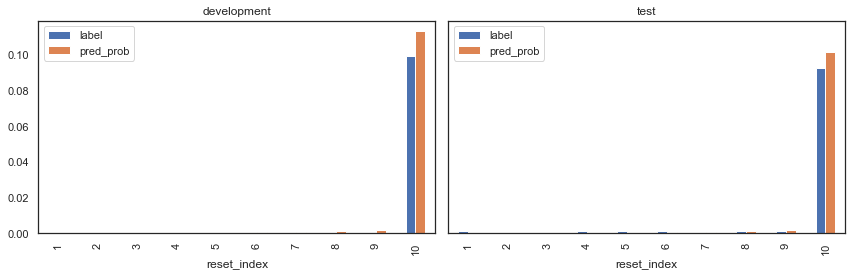

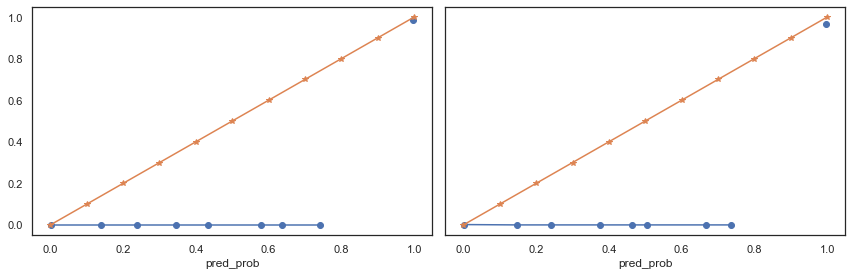

In [147]:
# Under Sampling with Class Ratio = 100
XGBoost_classifier(X_train_sampled_100, y_train_sampled_100, X_test_sampled_100, y_test_sampled_100)


=====XGBoost Classifier=====

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[21:51:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsampleBylevel, colsampleBytree, maxDepth, minChildWeight, numEarlyStoppingRounds, numRound } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Params: {'numRound': [200], 'numEarlyStoppingRounds': [50], 'eta': [0.1], 'gamma': [0.0], 'maxDepth': [3], 'minChildWeight': [1.0], 'subsample': [0.8], 'colsampleBytree': [1.0], 'colsam

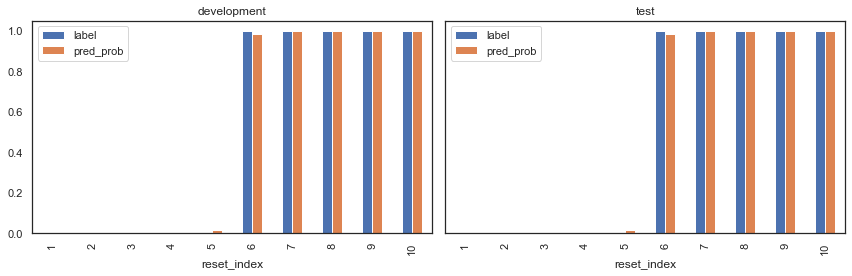

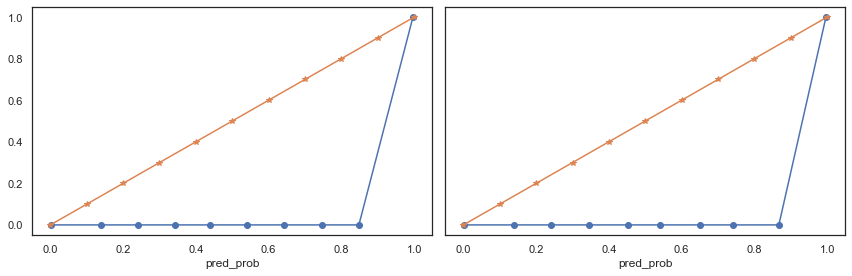

In [148]:
# Over sampling
XGBoost_classifier(X_train_oversampling, y_train_oversampling, X_test_oversampling, y_test_oversampling)


=====XGBoost Classifier=====

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[21:57:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsampleBylevel, colsampleBytree, maxDepth, minChildWeight, numEarlyStoppingRounds, numRound } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:57:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Params: {'numRound': [200], 'numEarlyStoppingRounds': [50], 'eta': [0.1], 'gamma': [0.0], 'maxDepth': [3], 'minChildWeight': [1.0], 'subsample': [0.8], 'colsampleBytree': [1.0], 'colsam

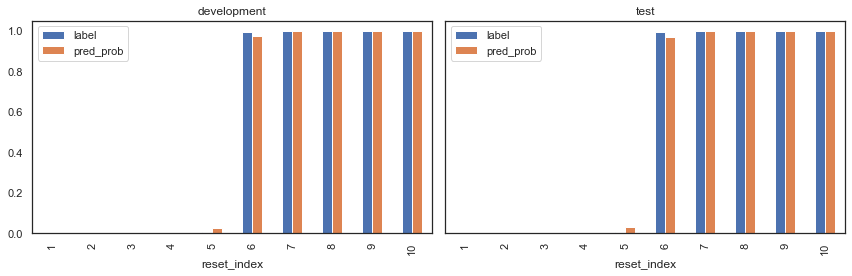

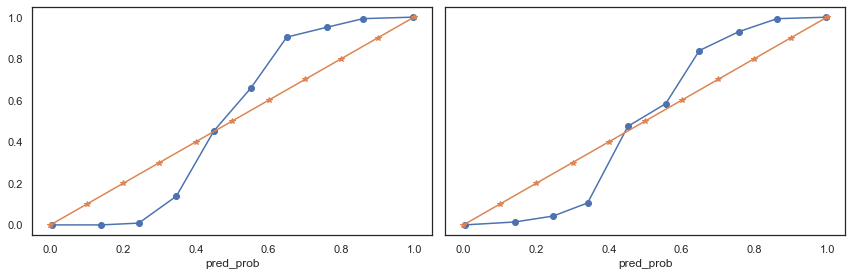

In [149]:
#SMOTE
XGBoost_classifier(X_train_SMOTE, y_train_SMOTE, X_test_SMOTE, y_test_SMOTE)